In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *

In [3]:
from bnbsl import *

In [4]:
SEASON = '21'
set_seed(int(SEASON))

## Data preparation

In [5]:
path = Path()
path_data = Path('data')

In [6]:
df = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])

In [7]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2']
df = df[(df.Div.isin(div)) & (df.Season >= 14) & (df.Season <= 21)]

# Drop NA corner
df = df.dropna().reset_index(drop=True)

In [8]:
add_datepart(df, 'Date');

In [9]:
# Time-weighted
df['weight'] = np.exp(-(df.Elapsed.max() - df.Elapsed) / (3600*24*365))
df['weight'] = df['weight'] / df['weight'].mean()

In [10]:
procs = [Categorify, FillMissing, Normalize]

In [11]:
valid_idx = list(df.query('Season == 21').index)

In [12]:
splitter = IndexSplitter(valid_idx)
splits = splitter(range_of(df))

In [13]:
splits

((#25771) [0,1,2,3,4,5,6,7,8,9...],
 (#1533) [2134,2135,2136,2137,2138,2139,2140,2141,2142,2143...])

In [14]:
y_names = ['HC', 'AC']
cat_names = ['Div', 'HomeTeam', 'AwayTeam', 'Dayofweek']
# cont_names = list(df.columns[df.columns.str.contains('For') | df.columns.str.contains('Against')]) + ['Year', 'Month', 'Week', 'Day', 'Dayofyear']
cont_names = list(df.columns[df.columns.str.contains('Avg')]) + ['Year', 'Month', 'Week', 'Day', 'Dayofyear']

In [15]:
y_block = RegressionBlock(n_out=2)

In [16]:
df.sample(10)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weight
8505,E1,Burton,Bolton,2.0,0.0,16.0,9.0,8.0,0.0,8.0,...,5,118,False,False,False,False,False,False,1.524874e+09,0.179210
435,D1,Mainz,Stuttgart,0.0,0.0,6.0,11.0,4.0,2.0,5.0,...,4,345,False,False,False,False,False,False,1.449792e+09,0.016572
22171,I2,Reggiana,Monza,3.0,0.0,10.0,16.0,5.0,5.0,2.0,...,6,341,False,False,False,False,False,False,1.607213e+09,2.439428
23271,SP1,Getafe,Real Madrid,1.0,5.0,12.0,21.0,5.0,11.0,5.0,...,5,107,False,False,False,False,False,False,1.460765e+09,0.023469
26868,SP2,Las Palmas,Alcorcon,0.0,0.0,4.0,13.0,0.0,4.0,3.0,...,6,348,False,False,False,False,False,False,1.607818e+09,2.486663
15693,F1,Angers,Guingamp,3.0,0.0,15.0,12.0,6.0,3.0,6.0,...,5,62,False,False,False,False,False,False,1.520035e+09,0.153720
1643,D1,Leverkusen,Schalke 04,2.0,1.0,19.0,5.0,9.0,3.0,9.0,...,5,341,False,False,False,False,False,False,1.575677e+09,0.897416
26444,SP2,Santander,Oviedo,1.0,1.0,16.0,13.0,5.0,6.0,9.0,...,5,355,False,False,False,False,False,False,1.576886e+09,0.932506
20965,I1,Inter,Benevento,4.0,0.0,13.0,0.0,8.0,0.0,7.0,...,5,30,False,False,False,False,False,False,1.611965e+09,2.836153
3218,D2,Bochum,Paderborn,3.0,0.0,17.0,11.0,9.0,4.0,6.0,...,4,346,False,False,False,False,False,False,1.607645e+09,2.473075


In [17]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [18]:
to.cat_names, to.cont_names

((#4) ['Div','HomeTeam','AwayTeam','Dayofweek'],
 (#29) ['FTHGLast5Avg','HSLast5Avg','HSTLast5Avg','HCLast5Avg','FTAGLast5Avg','ASLast5Avg','ASTLast5Avg','ACLast5Avg','HomeFTGForLast5Avg','HomeSForLast5Avg'...])

In [19]:
display_df(to.xs.iloc[-2:])

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear
27302,11,142,195,7,-1.006477,-0.304475,-0.756072,-0.597086,-0.634151,-0.413452,-0.553585,-0.262544,0.161600,0.858627,1.052455,0.599885,-0.209874,-0.027986,-0.381602,-0.047306,0.122424,-1.607604,-1.515842,-1.615225,0.178839,-0.380591,-0.823146,-0.696698,1.566972,1.1593,1.077186,-0.227662,1.133736
27303,11,162,260,1,-0.098619,0.103810,-0.472176,-0.463947,0.059633,-0.491622,-0.717658,-1.774162,-0.493334,-0.389475,-0.791496,0.167430,0.435405,0.044405,-0.078336,-1.744600,-0.223115,0.189129,-0.718973,-0.042823,-1.220320,-0.598991,-1.145628,-1.848342,1.566972,1.1593,1.136145,-0.114164,1.142186


### To other packages (e.g. Scikit-learn, LightGBM, XGBoost)

In [20]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [21]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

In [22]:
X_train.shape, y_train.shape

((19937, 33), (19937, 2))

In [23]:
X_test.shape, y_test.shape

((1533, 33), (1533, 2))

## LightGBM

In [24]:
fit_params = {'feature_name':list(X_test.columns), 'categorical_feature':cat_names}

In [25]:
m_lgbm = MultiOutputRegressor(LGBMRegressor(objective='poisson', n_estimators=100, n_jobs=-1, reg_lambda=1.0))
m_lgbm.fit(X_train, y_train, **fit_params)

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


MultiOutputRegressor(estimator=LGBMRegressor(objective='poisson',
                                             reg_lambda=1.0))

In [26]:
import lightgbm as lgbm

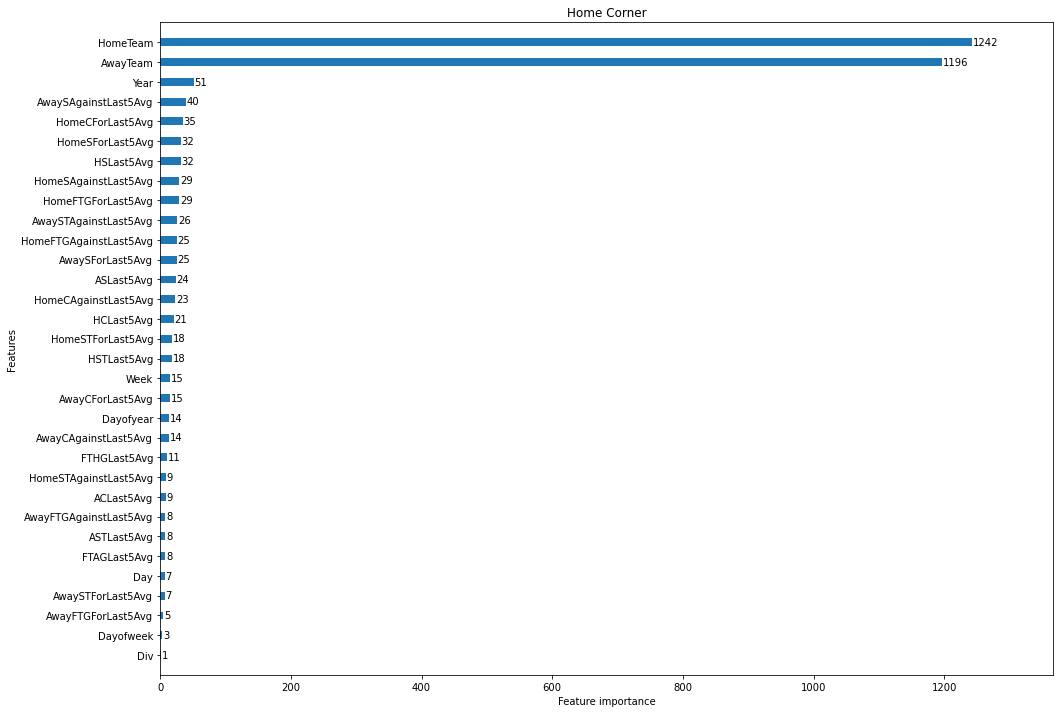

In [27]:
lgbm.plot_importance(m_lgbm.estimators_[0], figsize=(16, 12), title='Home Corner', max_num_features=40, height=0.4, grid=False);

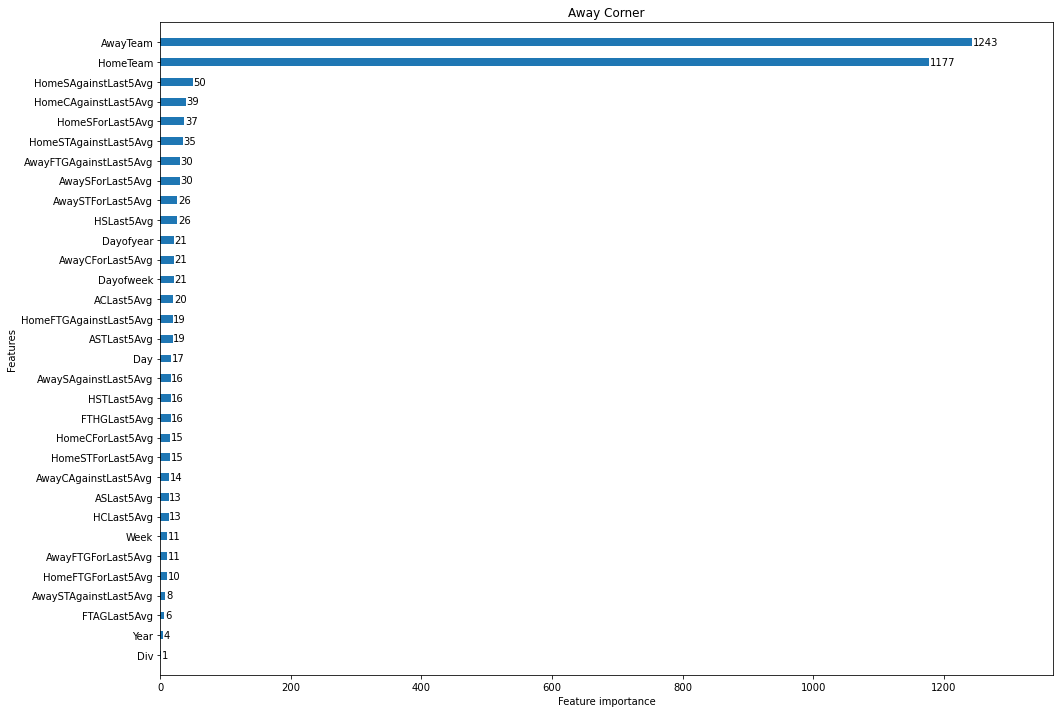

In [28]:
lgbm.plot_importance(m_lgbm.estimators_[1], figsize=(16, 12), title='Away Corner', max_num_features=40, height=0.4, grid=False);

## XGBoost

In [29]:
m_xgb = MultiOutputRegressor(XGBRegressor(objective='count:poisson', n_estimators=100, n_jobs=-1, tree_method='exact'))
m_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='count:poisson',
                                            rand

In [30]:
import xgboost as xgb

In [31]:
for i in range(0, 2):
    m_xgb.estimators_[i].get_booster().feature_names = list(X_test.columns)

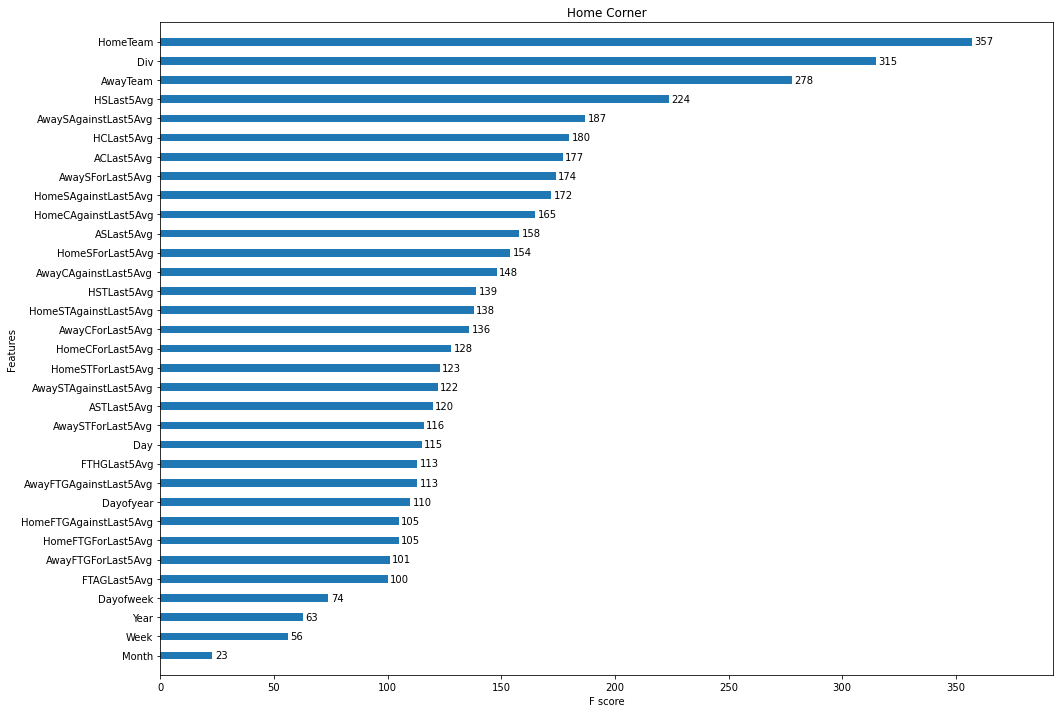

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[0], title='Home Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

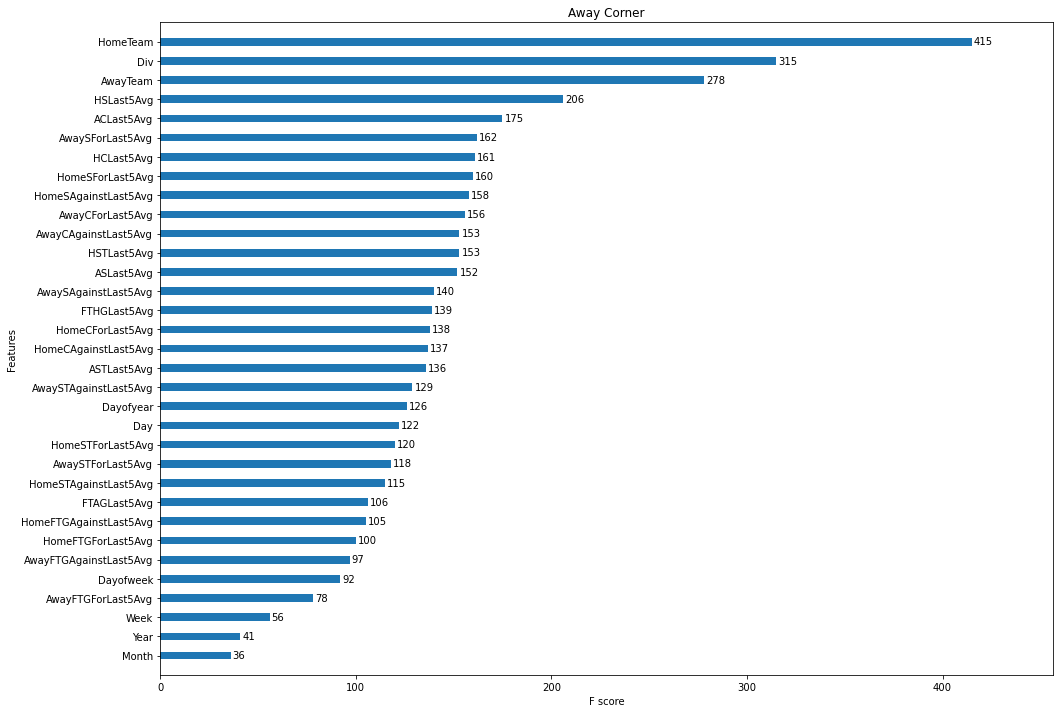

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[1], title='Away Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

## Poisson

In [34]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC
0,F2,Auxerre,Lorient,0,0.6,10.600000,2.2,3.6,1.2,8.6,3.8,4.4,1.2,12.2,4.2,5.8,1.0,10.0,3.4,4.4,0.8,9.8,3.8,3.4,1.0,9.4,2.0,4.4,2018.0,12.0,49.000000,3.0,336.999997,7.0,4.0
1,E0,Man City,Arsenal,6,2.6,16.200001,5.8,8.2,1.2,9.6,3.2,4.8,2.4,14.2,5.4,6.8,1.8,12.6,4.4,4.6,0.8,5.2,2.6,1.4,1.6,13.4,4.0,5.6,2019.0,2.0,5.000000,3.0,34.000001,4.0,2.0
2,F2,Grenoble,Caen,5,1.2,10.200000,3.2,5.4,1.2,8.2,3.0,3.0,1.2,10.8,3.0,4.2,0.6,10.6,3.8,3.6,1.2,10.0,3.8,2.8,1.6,11.0,4.6,4.8,2021.0,4.0,14.000000,10.0,99.999997,5.0,5.0
3,SP2,Tenerife,Reus Deportiu,5,1.2,13.000000,4.0,6.8,0.6,5.4,1.8,1.8,1.0,11.8,3.0,4.6,0.6,7.2,2.2,1.6,1.2,8.2,3.0,3.4,1.4,9.2,4.4,3.0,2018.0,9.0,37.000000,15.0,257.999997,8.0,3.0
4,I1,Sassuolo,Spal,6,2.0,12.600000,6.4,5.6,2.2,9.4,4.6,4.6,1.6,9.4,5.6,4.0,1.6,8.6,3.4,5.2,2.0,11.8,6.0,6.2,2.2,14.6,8.4,7.6,2019.0,9.0,38.000000,22.0,265.000002,7.0,9.0
5,F1,Marseille,Reims,5,2.0,10.800000,4.0,4.0,2.2,12.2,5.0,3.4,1.8,9.2,3.4,3.0,0.8,12.0,3.6,4.4,0.8,9.2,2.6,4.4,1.6,12.0,5.2,4.0,2020.0,12.0,51.000000,19.0,353.999999,7.0,3.0
6,E2,Gillingham,Bradford,5,1.4,12.000000,5.0,5.0,1.0,11.2,3.6,5.8,1.4,10.6,3.8,4.4,1.6,13.6,5.0,7.6,2.2,13.4,6.2,4.0,0.8,10.4,3.4,5.0,2016.0,9.0,36.000000,10.0,253.999998,5.0,4.0
7,SP2,Oviedo,Fuenlabrada,5,1.4,9.200000,3.2,5.2,1.0,11.8,3.6,4.2,2.2,10.0,4.4,4.6,1.0,10.0,3.4,4.0,1.4,11.0,4.8,4.6,1.4,10.8,3.2,6.4,2020.0,11.0,47.000000,21.0,326.000007,4.0,0.0
8,SP1,Sevilla,Ath Bilbao,5,1.4,13.600000,3.8,7.0,1.0,9.4,3.2,3.8,1.4,10.4,4.4,4.8,0.6,8.6,3.0,4.6,2.2,12.6,4.8,5.4,1.2,8.8,3.4,2.8,2018.0,3.0,9.000001,3.0,61.999993,8.0,4.0
9,E2,Milton Keynes Dons,Southend,5,0.8,17.200001,6.2,8.2,0.4,8.0,3.0,3.2,1.4,16.4,6.4,7.6,1.0,12.4,5.0,4.0,1.8,8.2,4.8,3.8,1.2,11.0,3.8,4.6,2016.0,10.0,42.000000,22.0,296.000001,10.0,7.0


In [35]:
learn = tabular_learner(dls, layers=[240, 120])

In [36]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(287, 38)
    (2): Embedding(287, 38)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=116, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=2, bias=True)
    )
  )
)

In [37]:
learn.loss_func = BaseLoss(partial(nn.PoissonNLLLoss, log_input=True, full=True), floatify=True)

SuggestedLRs(valley=0.004365158267319202)

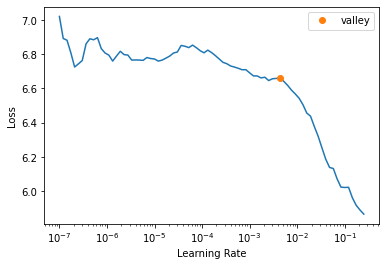

In [38]:
learn.lr_find()

In [39]:
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,2.460970,2.411526,00:02
1,2.398502,2.379346,00:02
2,2.329852,2.351069,00:02
3,2.316761,2.361088,00:02
4,2.305774,2.355986,00:02


In [40]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weight
4851,E0,Tottenham,Man City,1.0,0.0,13.0,18.0,3.0,4.0,3.0,...,6,227,False,False,False,False,False,False,1.628986e+09,3.836023


In [41]:
_, _, params = learn.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                               .drop(columns=y_names).iloc[0])

In [42]:
pois_corner_home = torch.distributions.poisson.Poisson(params[0].exp())
pois_corner_away = torch.distributions.poisson.Poisson(params[1].exp())

In [43]:
print(pois_corner_home.mean, pois_corner_home.variance)
print(pois_corner_away.mean, pois_corner_away.variance)

tensor(3.6801) tensor(3.6801)
tensor(5.9267) tensor(5.9267)


In [44]:
corner_home = pois_corner_home.log_prob(torch.arange(0., 15.)).exp()
corner_away = pois_corner_away.log_prob(torch.arange(0., 15.)).exp()
corner = torch.ger(corner_home, corner_away)
mask = torch.zeros_like(corner)

In [45]:
mask = torch.zeros_like(corner)
line = 10.5
for i in range(0, mask.size()[0]):
    for j in range(0, mask.size()[1]):
        if i + j < line: mask[i, j] = 1. 

In [46]:
prob_lo = (corner * mask).sum()
prob_hi = 1 - prob_lo

In [47]:
prob_lo, prob_hi

(tensor(0.6321), tensor(0.3679))

## Negative Binomial

In [20]:
y_names = ['HC', 'AC', 'weight']
y_block = RegressionBlock(n_out=5)

In [21]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [22]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC,weight
0,E2,Peterboro,Oxford,5,0.6,11.0,3.8,5.0,0.8,8.6,3.0,4.4,1.0,9.8,4.0,4.8,2.2,10.800000,5.4,5.2,0.8,11.6,4.0,7.2,1.4,7.8,3.4,4.8,2018.0,12.0,49.000000,8.0,341.999995,8.0,6.0,0.331046
1,E0,Man United,Newcastle,5,1.8,15.4,5.6,5.2,0.2,11.6,3.4,6.6,1.0,10.0,2.4,3.6,1.2,13.400000,4.6,6.2,0.4,9.6,3.6,5.0,1.4,10.8,3.8,3.6,2015.0,8.0,34.000000,22.0,234.000000,11.0,5.0,0.012227
2,E2,Shrewsbury,Rochdale,5,1.2,13.8,4.8,3.8,0.6,9.8,2.4,5.4,0.8,10.0,2.8,3.4,0.8,11.000000,3.4,7.0,1.0,10.2,4.0,3.2,1.6,12.8,3.6,5.0,2020.0,10.0,43.000000,24.0,297.999999,11.0,2.0,2.168326
3,I1,Sampdoria,Napoli,6,1.4,12.2,4.8,4.6,2.8,14.8,5.8,5.0,1.4,9.0,4.6,4.0,3.0,19.600001,6.8,6.4,2.4,15.4,5.2,6.2,0.8,10.8,3.2,4.0,2017.0,5.0,21.000000,28.0,148.000000,5.0,10.0,0.071575
4,F1,Monaco,Paris SG,6,2.0,15.6,5.6,6.6,3.4,12.4,7.0,4.8,1.8,13.6,4.6,5.0,2.6,15.200000,7.0,7.4,2.0,11.6,6.0,6.0,0.2,9.8,2.6,3.2,2016.0,8.0,34.000000,28.0,241.000000,2.0,7.0,0.033879
5,SP1,Eibar,Alaves,6,1.2,14.6,3.8,6.0,1.6,9.4,3.0,2.6,1.0,14.0,3.6,6.8,1.2,13.000000,3.2,4.6,2.2,8.4,4.4,3.0,0.8,13.6,5.2,5.8,2018.0,11.0,44.000000,4.0,308.000001,13.0,1.0,0.301602
6,E2,Rochdale,Bury,5,1.6,15.6,4.8,6.6,0.4,6.2,1.4,2.4,1.0,15.6,5.2,8.0,1.4,8.800000,4.0,2.8,1.6,10.2,5.2,3.4,1.6,12.0,5.4,5.4,2017.0,8.0,34.000000,26.0,238.000002,3.0,1.0,0.091590
7,E1,Reading,Barnsley,5,1.6,12.0,4.6,3.4,1.2,12.4,3.8,3.6,1.6,11.0,4.6,3.4,1.0,12.400000,3.8,3.6,1.2,15.4,3.4,4.2,1.4,13.6,4.4,6.4,2017.0,2.0,6.000001,11.0,41.999997,12.0,3.0,0.053535
8,I1,Udinese,Inter,6,1.2,9.2,4.2,3.8,2.0,9.8,7.4,6.0,1.6,10.8,5.4,6.0,2.0,11.800000,7.4,5.6,1.2,12.4,5.6,6.6,0.8,10.6,5.0,3.8,2020.0,2.0,4.999999,2.0,32.999995,3.0,2.0,1.049095
9,SP2,Oviedo,Almeria,4,1.6,12.0,3.8,6.0,1.6,7.6,3.0,2.6,1.8,10.4,3.8,4.2,1.4,10.400000,3.4,3.4,1.2,14.4,4.4,6.2,1.6,13.2,5.2,5.4,2019.0,11.0,44.000000,1.0,304.999995,5.0,3.0,0.813128


In [23]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [24]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(293, 39)
    (2): Embedding(293, 39)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=118, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [25]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.013976634480059147)

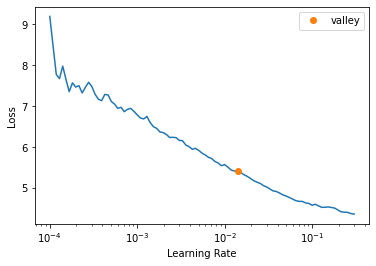

In [26]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [27]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,3.546786,25.993696,00:03
1,3.376252,25.708693,00:03
2,3.483357,25.513342,00:03
3,3.348074,25.669432,00:03
4,3.371711,25.731552,00:03


In [28]:
df.query('Season==21 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')[['HC', 'AC']]

,HC,AC
6259,4.0,13.0


In [29]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [30]:
_, params = learn_bnb.predict(df.query('Season==21 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')
                                .drop(columns=y_names).iloc[0])

In [31]:
params

tensor([ -2.4509,  -2.5009,   4.5105,   4.9413, -42.5484])

In [32]:
alpha = F.softplus(params[0:2])
mu = F.softplus(params[2:4])
omega = params[4]
# omega = torch.tanh(params[4]) * 50.

total_count = 1. / alpha
logits = torch.log(alpha * mu)

print(alpha, mu, omega)

tensor([0.0827, 0.0788]) tensor([4.5214, 4.9484]) tensor(-42.5484)


In [33]:
bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)

In [34]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([4.5214, 4.9484]) tensor([6.2120, 6.8786])


In [35]:
# Method 1:
corr = omega * torch.sqrt(mu.prod()) * alpha.prod() / ((1.+alpha)**(1./alpha+1.)).prod() / torch.sqrt((1.+alpha*mu).prod())
corr 

tensor(-0.1188)

In [36]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod()*(1.+alpha*mu).prod()) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod()
# corr 

In [37]:
value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [38]:
corner = bnb_corner.log_prob(value).exp()

In [39]:
line = 10.5
mask = value.sum(-1) < line
prob_lo = corner[mask].sum()
prob_hi = 1 - prob_lo

In [40]:
prob_lo, prob_hi

(tensor(0.6437), tensor(0.3563))

In [41]:
1/prob_lo, 1/prob_hi

(tensor(1.5536), tensor(2.8063))

### Train full model

In [42]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block)

In [43]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC,weight
0,F1,Nantes,Monaco,4,0.8,11.400000,4.8,5.6,0.6,13.0,4.8,4.6,0.8,10.4,2.8,4.2,2.2,15.6,6.2,5.2,0.6,10.6,3.6,4.8,1.4,11.6,4.2,4.6,2019.0,10.0,43.000000,25.0,297.999997,5.0,3.0,0.797683
1,D1,Hoffenheim,Hamburg,6,1.4,16.600000,4.6,4.4,0.2,8.6,1.4,2.2,1.8,15.6,6.2,4.8,0.4,9.4,2.2,3.0,0.6,12.6,3.8,5.8,2.6,15.4,5.0,5.8,2016.0,11.0,46.000001,20.0,324.999995,8.0,6.0,0.042646
2,E2,Bradford,Oxford,5,0.6,11.800000,3.4,5.0,1.0,9.6,2.6,5.0,0.6,10.6,4.0,5.4,1.6,9.0,3.8,3.8,2.4,12.4,5.8,5.8,0.8,9.4,3.4,4.8,2018.0,11.0,47.000000,24.0,328.000004,2.0,8.0,0.318589
3,E1,Brentford,Barnsley,6,3.2,16.200001,7.6,5.6,0.4,9.2,1.8,4.0,3.6,16.0,7.2,5.2,0.4,11.6,2.4,4.4,1.4,7.8,3.8,4.4,1.2,8.8,3.2,4.8,2021.0,2.0,6.000001,14.0,44.999994,7.0,5.0,2.955136
4,E2,Peterboro,Gillingham,0,1.8,13.800000,6.0,4.6,0.8,10.8,4.2,5.4,1.8,15.2,5.0,2.8,1.2,11.0,4.8,4.8,0.8,11.6,2.6,5.6,1.2,14.0,3.8,5.4,2016.0,12.0,52.000000,26.0,360.999998,4.0,8.0,0.047067
5,F1,Dijon,Brest,6,1.8,13.000000,3.0,5.0,0.4,11.6,3.4,3.6,0.8,10.2,2.2,2.4,0.8,13.2,3.6,6.8,2.2,17.0,7.0,6.8,2.2,11.2,4.0,4.0,2020.0,9.0,37.000000,13.0,257.000001,5.0,7.0,1.937942
6,SP1,Malaga,Sociedad,5,1.4,15.600000,5.8,5.6,1.0,8.6,2.8,4.6,1.2,11.4,3.6,3.2,1.8,12.8,3.8,6.0,0.8,10.0,3.8,6.8,1.2,14.0,4.6,7.0,2015.0,4.0,14.000000,4.0,93.999999,12.0,3.0,0.008332
7,F1,Strasbourg,Lille,6,1.0,12.600000,3.4,5.6,1.4,12.0,4.6,5.4,0.8,11.0,3.8,3.4,1.2,11.4,4.2,4.4,2.0,8.0,4.0,4.2,0.4,9.6,2.4,3.6,2020.0,10.0,40.000000,4.0,278.000003,11.0,1.0,2.052710
8,E2,Charlton,Gillingham,5,2.0,9.800000,4.4,5.0,1.6,9.2,2.8,4.6,2.0,8.0,4.0,4.0,1.4,10.6,2.8,5.4,1.0,13.2,5.2,8.8,1.4,15.4,6.2,5.6,2018.0,12.0,51.000001,22.0,355.999998,9.0,7.0,0.343991
9,F2,Ajaccio,Paris FC,5,1.8,10.000000,4.8,5.4,1.2,12.6,4.6,4.6,1.2,11.0,3.4,5.4,1.2,11.2,4.2,5.2,1.0,9.0,2.2,4.8,1.0,7.6,2.0,4.8,2021.0,5.0,18.000000,8.0,128.000003,5.0,0.0,3.709666


In [44]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [45]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(293, 39)
    (2): Embedding(293, 39)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=118, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [46]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.018045615404844284)

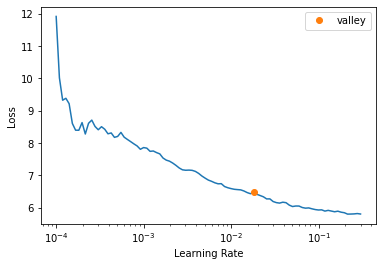

In [47]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [48]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.790655,None,00:03
1,4.710801,None,00:03
2,4.548855,None,00:03
3,4.625413,None,00:03
4,4.464023,None,00:03


/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [49]:
learn_bnb.export('models/learn_bnbsl.pkl')

In [50]:
to.export('models/to.pkl')

### t-SNE

In [52]:
df['HomeTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [53]:
df['AwayTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [54]:
variable = 'HomeTeam'
ix = cat_names.index(variable)

var_vals = list(df[variable].astype('category').cat.categories.values)
nval = len(var_vals)
print(f'Number of values: {nval}')
print(var_vals)

Number of values: 267
['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves', 'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre', 'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento', 'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux', 'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly', 'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo', 'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry', 'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt', 'Derby', 'Dijon', 'Doncaster', 'Dortmund', 'Dresden', 'Duisburg', 'Dunkerque', 'Eibar', 'Ein Frankfurt

In [55]:
# import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

emb_mx = to_np(next(learn_bnb.model.embeds[ix].parameters()))
#X_emb = TSNE(n_components=2, perplexity=3).fit_transform(emb_mx)
#X_emb = PCA(n_components=2).fit_transform(emb_mx)
annotation = np.append('Other', np.array(var_vals))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' 

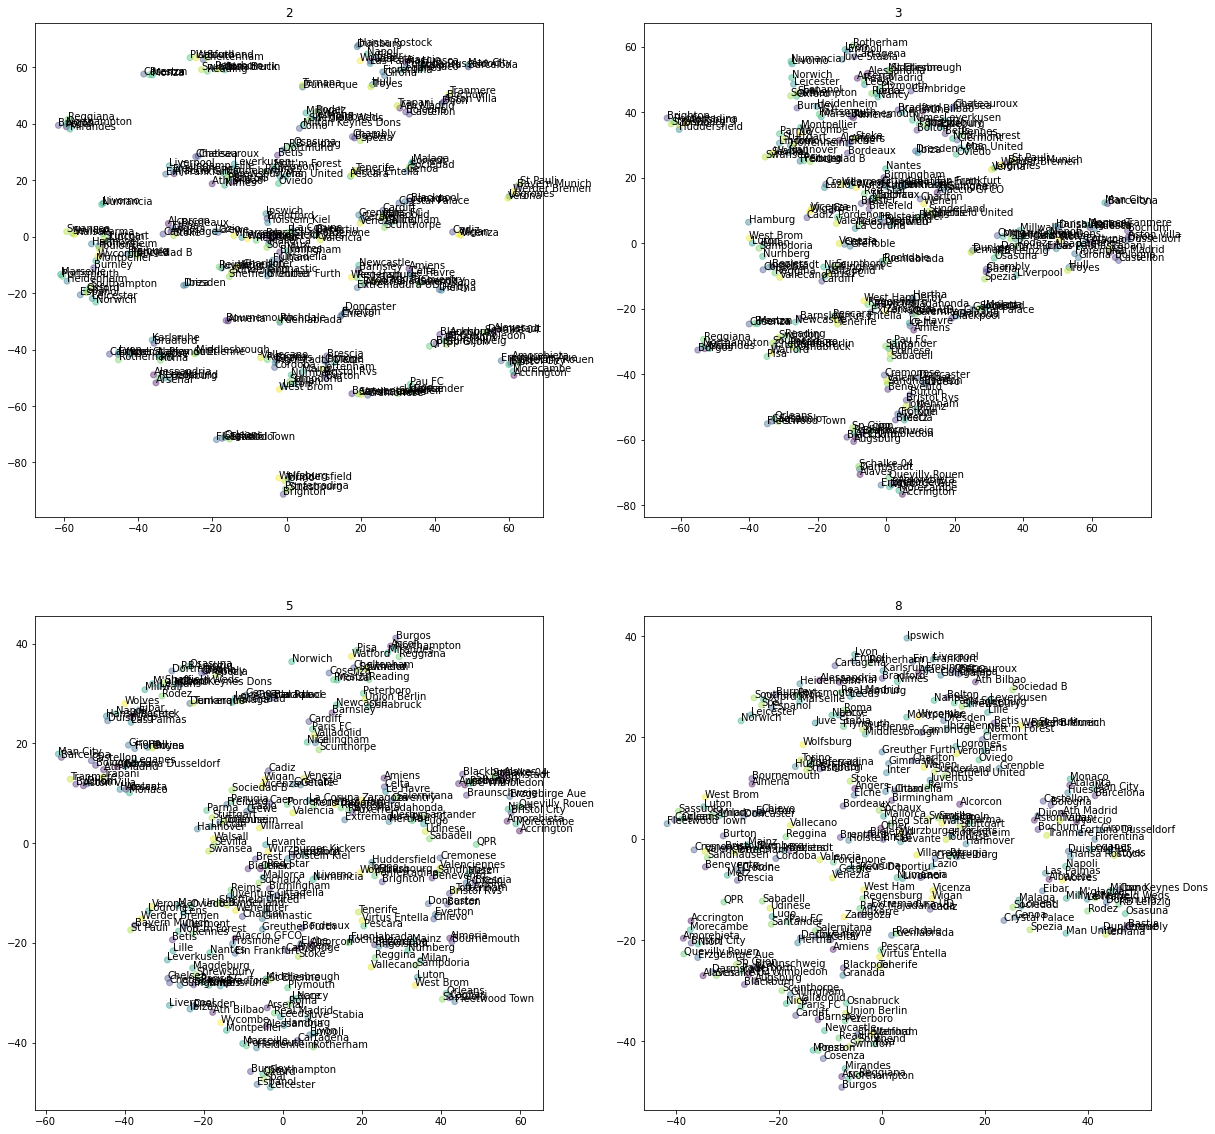

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

perplexity = [2, 3, 5, 8]
for ax,perp in zip(axes.flatten(), perplexity):
    X_emb = TSNE(n_components=2, perplexity=perp).fit_transform(emb_mx)
    ax.scatter(X_emb[:,0], X_emb[:,1], c=range(len(annotation)), alpha=0.4)
    for xy,target in zip(X_emb, annotation):
        if isinstance(target, np.str_) or isinstance(target, str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(text=text, xy=(xy[0], xy[1]))
        ax.set_title(perp)

# END